<a href="https://colab.research.google.com/github/StanleyLiangYork/PytorchCode/blob/main/CNN_for_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To compare a Convolutional Neural Network using Batch Normalization with a regular Convolutional Neural Network to classify handwritten digits from the MNIST database

In [1]:
# !pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
IMAGE_SIZE = 32

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [5]:
type(train_dataset[0][1])

int

In [6]:
# show label of the 4th image
train_dataset[3][1]

1

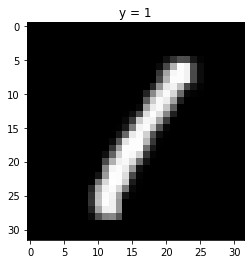

In [7]:
# show the 4th image
show_data(train_dataset[3])

In [9]:
# build a CNN without batch normalization
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [10]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [27]:
def train_model(model,criterion, train_loader,validation_loader,optimizer,n_epochs=5):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(n_epochs):
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        model.train()
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.data.item())

      correct=torch.tensor([0], dtype=torch.int32, requires_grad=False)
      # perform a prediction on the validation  data  
      for x_test, y_test in validation_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        model.eval()
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
      # compute accuracy
      correct_cpu = correct.cpu()
      accuracy = correct_cpu / N_test
      accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [28]:
# Create the model object using CNN class
model = CNN(out_1=16, out_2=32)

In [29]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [30]:
# Train the model
accuracy_list_normal, loss_list_normal=train_model(model=model, criterion=criterion, train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer, n_epochs=10)

In [31]:
model_batch=CNN_batch(out_1=16, out_2=32)
learning_rate = 0.1
optimizer = torch.optim.SGD(model_batch.parameters(), lr = learning_rate)
accuracy_list_batch, loss_list_batch=train_model(model=model_batch,criterion=criterion, n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

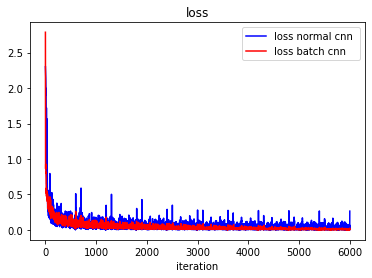

In [33]:
# Plot the loss and accuracy

plt.plot(loss_list_normal, 'b',label='loss normal cnn ')
plt.plot(loss_list_batch,'r',label='loss batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()

/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


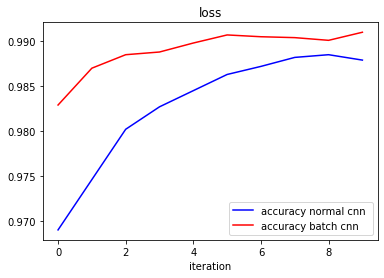

In [34]:
plt.plot(accuracy_list_normal, 'b',label='accuracy normal cnn ')
plt.plot(accuracy_list_batch,'r',label='accuracy batch cnn')
plt.xlabel('iteration')
plt.title("loss")
plt.legend()